In [11]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import os
import torch
import yaml 

In [12]:
class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)

def t2np(t):
    return ((t.permute(0,2, 3, 1) + 1) / 2).clamp(0,1).cpu().numpy()

In [13]:
with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config/cpg0000_multimodal_leaveout.yaml", "rb") as file:
    config_dict = yaml.safe_load(file)
    
args = OmegaConf.create(config_dict)
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240314_ae2fd4f5-9473-4381-b65e-4e8af89e5cd2_cpg0000_multimodal_leaveout"

In [14]:
args

{'task_name': 'cpg0000_multimodal_leaveout', 'img_size': 96, 'latent_dim': 100, 'hidden_dim': 512, 'style_dim': 64, 'stochastic': True, 'z_dimension': 20, 'dim_in': 64, 'lambda_reg': 1, 'lambda_cyc': 1, 'lambda_sty': 1, 'lambda_ds': 1, 'total_epochs': 100, 'ds_iter': 200000, 'resume_iter': 0, 'batch_size': 32, 'val_batch_size': 20, 'lr': 0.0001, 'f_lr': 0.0001, 'beta1': 0, 'beta2': 0.99, 'weight_decay': 0.0001, 'num_outs_per_domain': 10, 'single_style': True, 'mol_list': None, 'balanced': False, 'trainable_emb': False, 'dataset_name': 'cpg0000', 'n_channels': 5, 'num_workers': 6, 'seed': 42, 'image_path': '/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/cpg0000_u2os_normalized_segmented_large_transported', 'data_index_path': '/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large_gene2vec.csv', 'experiment_directory': '../project_folder/experiments', 'sample_dir': 'sample', 'checkpoint_dir': 'checkpoint', 'basal_vs_real_folder': 'basal_vs_real', 'nami

In [15]:
dataloader = CellDataLoader(args)

{'CRISPR': 328, 'Compound': 1224, 'ORF': 456}


In [16]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(100)
solver = solver.cuda()

Number of parameters in generator: 24319877
Number of parameters in style_encoder: 14330624
Number of parameters in discriminator: 14663561
Number of parameters in mapping_network: 132544
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): ModuleList(
    (0): Embedding(281, 328)
    (1): Embedding(277, 1224)
    (2): Embedding(155, 456)
  )
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm

In [17]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

**Check a bunch of drugs**

In [25]:
pert_to_inspect = ["1-octanol", "7-hydroxystaurosporine", "AVL-292", "AZD7762", "BI-2536", "BMS-536924", 
                      "BVT-948", "GK921", "GSK1070916", "GSK2110183", "KG-5", "NSC-663284", 
                      "NSC-95397", "PP-121", "RGB-286638", "SU3327", "TG-02", "TG-101348", "UNC1999", 
                      "UNC2025", "anisomycin", "azeliragon", "briciclib", "delanzomib", 
                      "dexamethasone", "homoharringtonine", "ibutamoren", "ixabepilone", "oxibendazole",
                      "ponatinib", "puromycin", "pyrrolidine-dithiocarbamate", "romidepsin", "ryuvidine"]

# Convert these drugs to their sample id 
data_index = pd.read_csv("/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large_gene2vec.csv")
pert_to_inspect_broad_id = {key:val  for key,val in zip(data_index.CPD_NAME, data_index.BROAD_SAMPLE) if key in pert_to_inspect}

In [26]:
pert_to_inspect_broad_id

{'GSK2110183': 'BRD-K25412176-001-01-9',
 'GSK1070916': 'BRD-K36740062-001-06-6',
 'dexamethasone': 'BRD-K38775274-001-22-1',
 'KG-5': 'BRD-K90747162-001-01-4',
 'TG-02': 'BRD-K14560436-001-01-4',
 'ixabepilone': 'BRD-K03601870-001-01-2',
 'delanzomib': 'BRD-K59325863-001-04-4',
 'NSC-95397': 'BRD-K68143200-001-11-7',
 '7-hydroxystaurosporine': 'BRD-K45293975-001-02-0',
 'AZD7762': 'BRD-K86525559-001-07-8',
 'BMS-536924': 'BRD-K34581968-001-05-3',
 'ibutamoren': 'BRD-K44771174-066-01-0',
 '1-octanol': 'BRD-K09338665-001-08-9',
 'BI-2536': 'BRD-K64890080-001-02-1',
 'PP-121': 'BRD-K81801188-001-02-8',
 'GK921': 'BRD-K38272302-001-02-7',
 'AVL-292': 'BRD-K87782578-001-01-4',
 'oxibendazole': 'BRD-K52075715-001-06-7',
 'homoharringtonine': 'BRD-K76674262-001-03-3',
 'UNC2025': 'BRD-K91283740-003-01-6',
 'TG-101348': 'BRD-K12502280-001-11-4',
 'RGB-286638': 'BRD-K20986415-001-02-6',
 'BVT-948': 'BRD-A22713669-001-04-3',
 'romidepsin': 'BRD-K61397605-001-01-8',
 'briciclib': 'BRD-K05531427-

In [27]:
solver.embedding_matrix[1]

Embedding(277, 1224)

In [41]:
transf_images = {}
real_images = {}

# z_common = torch.randn(1, 100, args.z_dimension).mean(1).cuda()
with torch.no_grad():
    for batch in train_dataloader:
        X_ctr = batch["X"][0]
        for pert in tqdm(pert_to_inspect_broad_id):
            # Get embeddings
            try:
                id_pert = dataloader.mol2id["Compound"][pert_to_inspect_broad_id[pert]]
                id_pert = torch.tensor(id_pert).cuda()
                y = solver.embedding_matrix[1](id_pert).unsqueeze(0).repeat(X_ctr.shape[0], 1)
                # Get random vec
                z = torch.randn(X_ctr.shape[0], 100, args.z_dimension).mean(1).cuda()
                y = torch.cat([y, z], dim=1)
                y = solver.nets.mapping_network(y, None, 1)
                _, X_generated = solver.nets.generator(X_ctr, y)
                transf_images[pert] = t2np(X_generated.detach().cpu())
                real_images[pert] = t2np(X_ctr.detach().cpu())

            except:
                continue
        break

100%|██████████| 34/34 [00:01<00:00, 19.54it/s]


In [42]:
solver.nets.mapping_network

DataParallel(
  (module): MappingNetwork(
    (mapping_network): ModuleList(
      (0): MappingNetworkSingleStyle(
        (layers): Sequential(
          (0): Linear(in_features=348, out_features=64, bias=True)
        )
      )
      (1): MappingNetworkSingleStyle(
        (layers): Sequential(
          (0): Linear(in_features=1244, out_features=64, bias=True)
        )
      )
      (2): MappingNetworkSingleStyle(
        (layers): Sequential(
          (0): Linear(in_features=476, out_features=64, bias=True)
        )
      )
    )
  )
)

GSK2110183
real


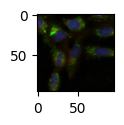

transf


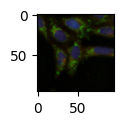

real


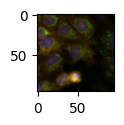

transf


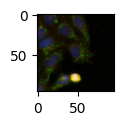

real


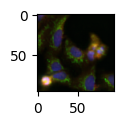

transf


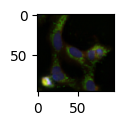

real


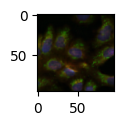

transf


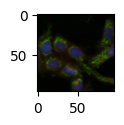

GSK1070916
real


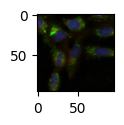

transf


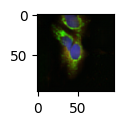

real


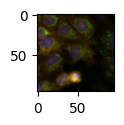

transf


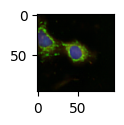

real


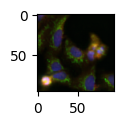

transf


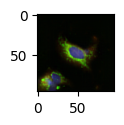

real


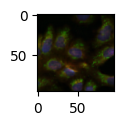

transf


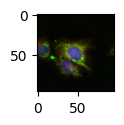

dexamethasone
real


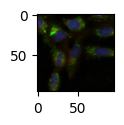

transf


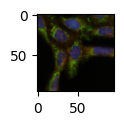

real


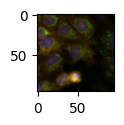

transf


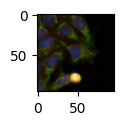

real


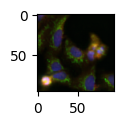

transf


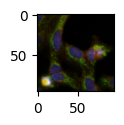

real


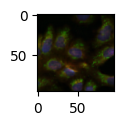

transf


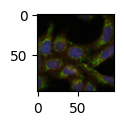

delanzomib
real


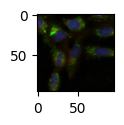

transf


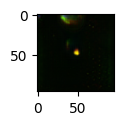

real


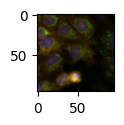

transf


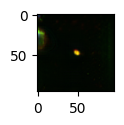

real


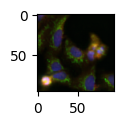

transf


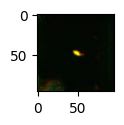

real


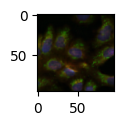

transf


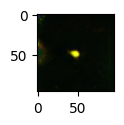

NSC-95397
real


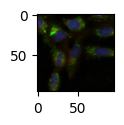

transf


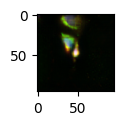

real


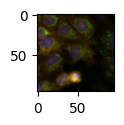

transf


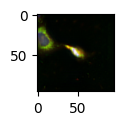

real


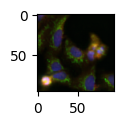

transf


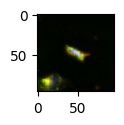

real


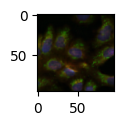

transf


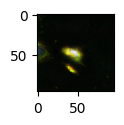

7-hydroxystaurosporine
real


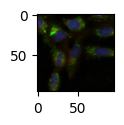

transf


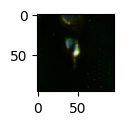

real


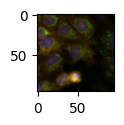

transf


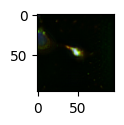

real


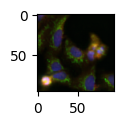

transf


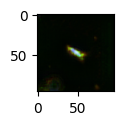

real


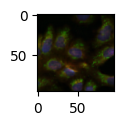

transf


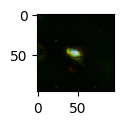

AZD7762
real


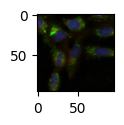

transf


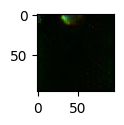

real


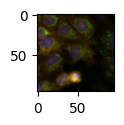

transf


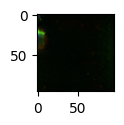

real


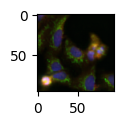

transf


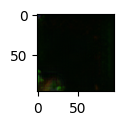

real


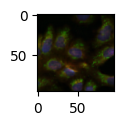

transf


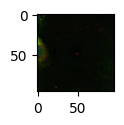

BMS-536924
real


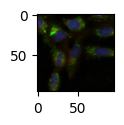

transf


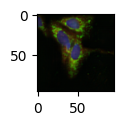

real


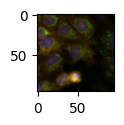

transf


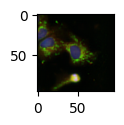

real


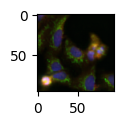

transf


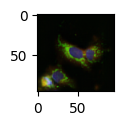

real


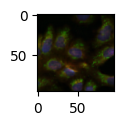

transf


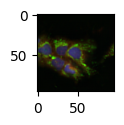

ibutamoren
real


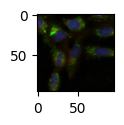

transf


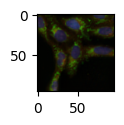

real


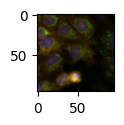

transf


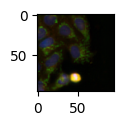

real


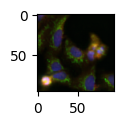

transf


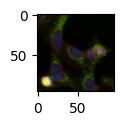

real


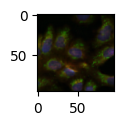

transf


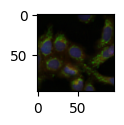

1-octanol
real


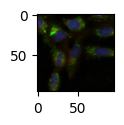

transf


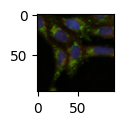

real


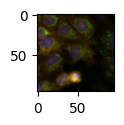

transf


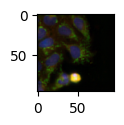

real


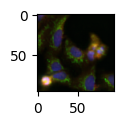

transf


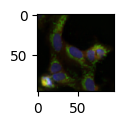

real


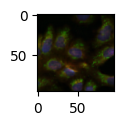

transf


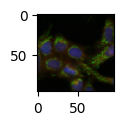

BI-2536
real


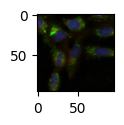

transf


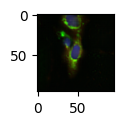

real


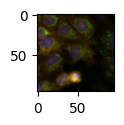

transf


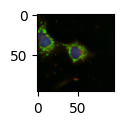

real


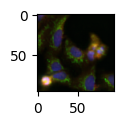

transf


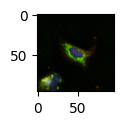

real


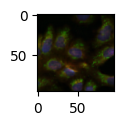

transf


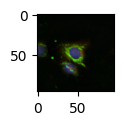

PP-121
real


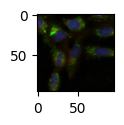

transf


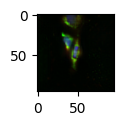

real


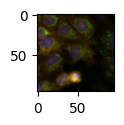

transf


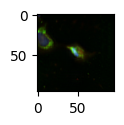

real


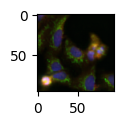

transf


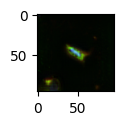

real


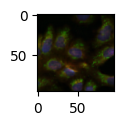

transf


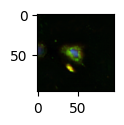

GK921
real


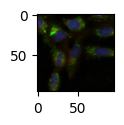

transf


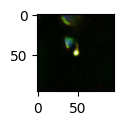

real


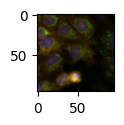

transf


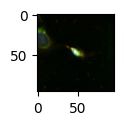

real


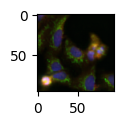

transf


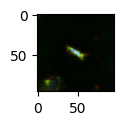

real


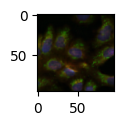

transf


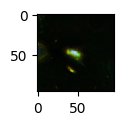

AVL-292
real


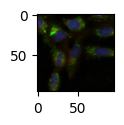

transf


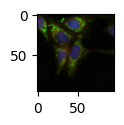

real


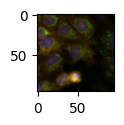

transf


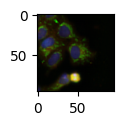

real


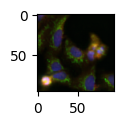

transf


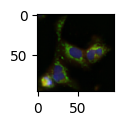

real


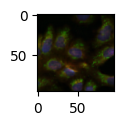

transf


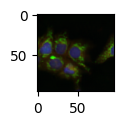

oxibendazole
real


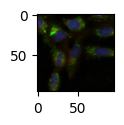

transf


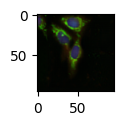

real


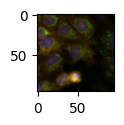

transf


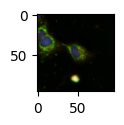

real


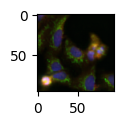

transf


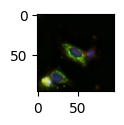

real


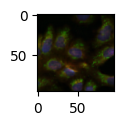

transf


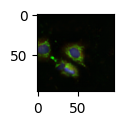

UNC2025
real


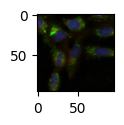

transf


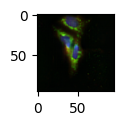

real


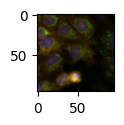

transf


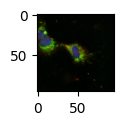

real


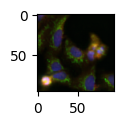

transf


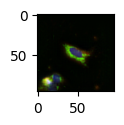

real


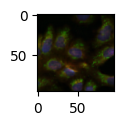

transf


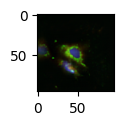

TG-101348
real


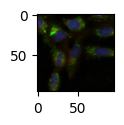

transf


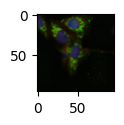

real


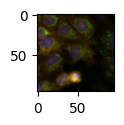

transf


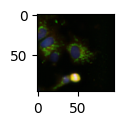

real


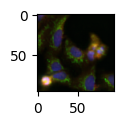

transf


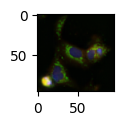

real


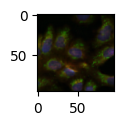

transf


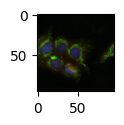

RGB-286638
real


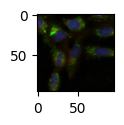

transf


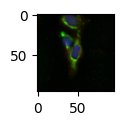

real


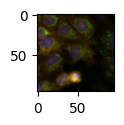

transf


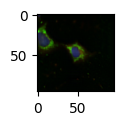

real


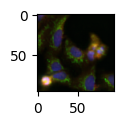

transf


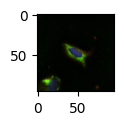

real


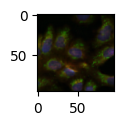

transf


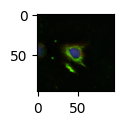

romidepsin
real


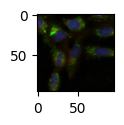

transf


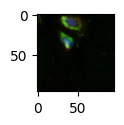

real


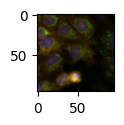

transf


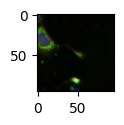

real


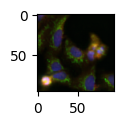

transf


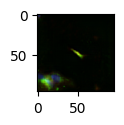

real


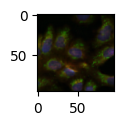

transf


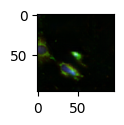

briciclib
real


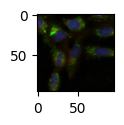

transf


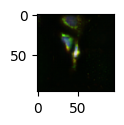

real


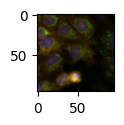

transf


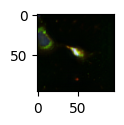

real


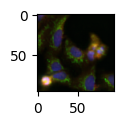

transf


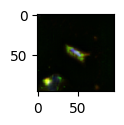

real


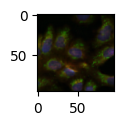

transf


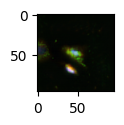

ryuvidine
real


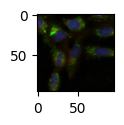

transf


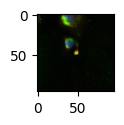

real


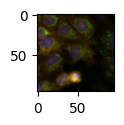

transf


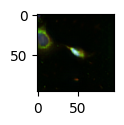

real


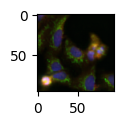

transf


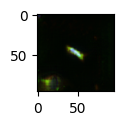

real


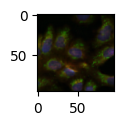

transf


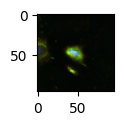

UNC1999
real


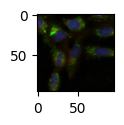

transf


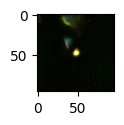

real


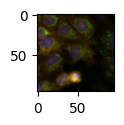

transf


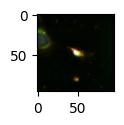

real


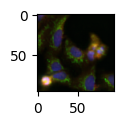

transf


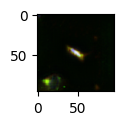

real


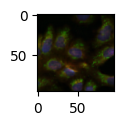

transf


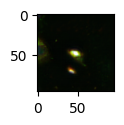

anisomycin
real


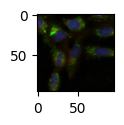

transf


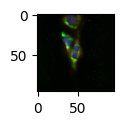

real


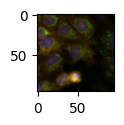

transf


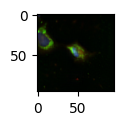

real


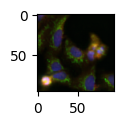

transf


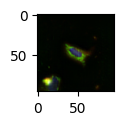

real


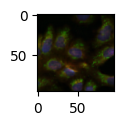

transf


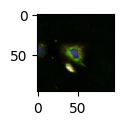

SU3327
real


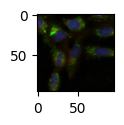

transf


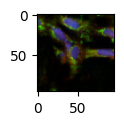

real


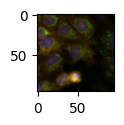

transf


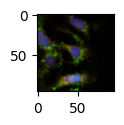

real


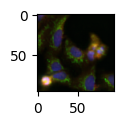

transf


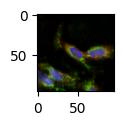

real


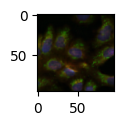

transf


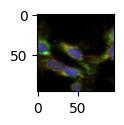

azeliragon
real


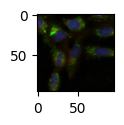

transf


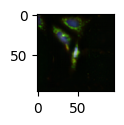

real


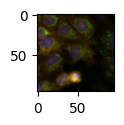

transf


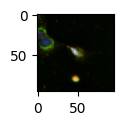

real


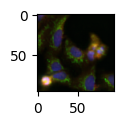

transf


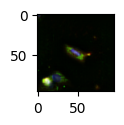

real


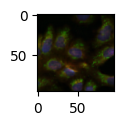

transf


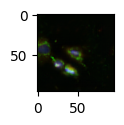

ponatinib
real


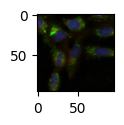

transf


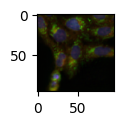

real


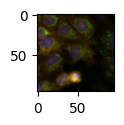

transf


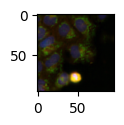

real


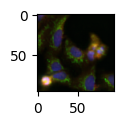

transf


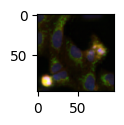

real


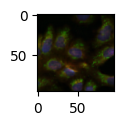

transf


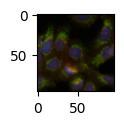

pyrrolidine-dithiocarbamate
real


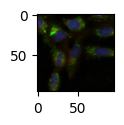

transf


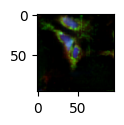

real


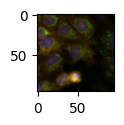

transf


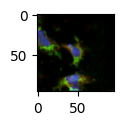

real


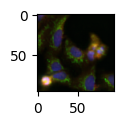

transf


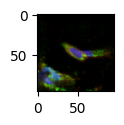

real


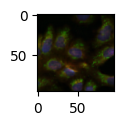

transf


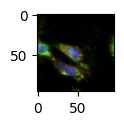

In [43]:
for pert in transf_images:
    print(pert)
    for i in range(len(batch)):
        print("real")
        plt.figure(figsize=(1,1))
        plt.imshow(real_images[pert][i][:,:,[0,3,4]])
        plt.show()
        print("transf")
        plt.figure(figsize=(1,1))
        plt.imshow(transf_images[pert][i][:,:,[0,3,4]])
        plt.show()  